In [1]:
from __future__ import print_function
from __future__ import division

from typing import List, Optional, Iterable, Union, Dict

import os
import pandas as pd
import numpy as np
import re
import itertools

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import optuna

import copy
from itertools import combinations

from numba import cuda

from warnings import filterwarnings
filterwarnings('ignore')

from scipy.signal import medfilt

import pickle

/home/tfc/anaconda3/envs/DD_dengue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess(df_features_or: pd.DataFrame,
               labels=None,
               features_to_keep: Optional[Iterable[str]] = None,
               lagged_features: Optional[Union[Iterable[str],Dict[str, Iterable[str]]]] = None,
               fillna: Optional[str] = None,
               circular_weekofyear: bool = False,
               feature_lags=None,
               label_lags=None):
    '''
    Add lagged features or target values as needed, accounting for existence of two cities in dataset.
    fillna: Fill NaN approach, e.g. 'ffill'. None to not fill.
    '''

    df_features = df_features_or.copy()
    df_features = df_features.reset_index()

    if features_to_keep is not None:         # Filter features
        feature_names = features_to_keep + ['city']
        df_features = df_features[feature_names]
    else:
        feature_names = list(df_features.columns)

    if fillna is not None:                   # Fill NaNs
        df_features.fillna(method=fillna, inplace=True)

    # Convert city feature to categorical and one hot encode
    df_features["city"] = df_features["city"].astype("category")
    df_features = pd.get_dummies(df_features, columns=['city'], drop_first=True)

    # Create circular week of year. #TEMP: update again
    if circular_weekofyear:
        # df_features['weekofyear1'] = np.sin((df_features['weekofyear']-1)/51*2*np.pi)
        # df_features['weekofyear2'] = np.cos((df_features['weekofyear']-1)/51*2*np.pi)
        # df_features.drop(columns=['weekofyear'],inplace=True)
        df_features['weekofyear'] = np.sin((df_features['weekofyear']-1)/51*np.pi)
        
    # Split cities before adding lags
    sj_features = df_features[df_features['city_sj']]
    iq_features = df_features[~df_features['city_sj']]

    if labels is not None:
        sj_labels = labels[df_features['city_sj']]
        iq_labels = labels[~df_features['city_sj']]
    else:
        sj_labels = None        
        iq_labels = None

    # Lagged feature/labels creation
    if (lagged_features is not None) or (label_lags is not None):
        # Add lagged features
        if isinstance(lagged_features,dict):                # Do individual lags for different features
            for feat, feat_lags in lagged_features.items():
                sj_features_lagged = sj_features[feat].shift(periods=feat_lags)
                sj_features = pd.concat([sj_features,sj_features_lagged],axis=1)
                iq_features_lagged = iq_features[feat].shift(periods=feat_lags)
                iq_features = pd.concat([iq_features,iq_features_lagged],axis=1)
        elif isinstance(lagged_features, (list, tuple)):    # All considered features has same lags
            for feat in lagged_features:
                if 'total_cases' in feat:                   # Skip all total_cases features, used when preprocessing pred features
                    continue
                sj_features_lagged = sj_features[feat].shift(periods=feature_lags)
                sj_features = pd.concat([sj_features,sj_features_lagged],axis=1)
                iq_features_lagged = iq_features[feat].shift(periods=feature_lags)
                iq_features = pd.concat([iq_features,iq_features_lagged],axis=1)

        # Add lagged labels
        if label_lags is not None:
            sj_lagged_labels = sj_labels.shift(periods=label_lags)
            sj_features = pd.concat([sj_features,sj_lagged_labels],axis=1)
            iq_lagged_labels = iq_labels.shift(periods=label_lags)
            iq_features = pd.concat([iq_features,iq_lagged_labels],axis=1)
  
    return sj_features, iq_features, sj_labels, iq_labels

def prep_data(sj_features:pd.DataFrame, iq_features:pd.DataFrame,
              sj_labels:pd.DataFrame, iq_labels:pd.DataFrame,
              folds=6, fold_size=0.15):
    '''
    To prepare multiple folds for k-fold, without randomization to preserve time series sequence.
    sj_features: Dataframe of processed input for San Juan
    iq_features: Dataframe of processed input for Iquitos
    sj_labels: Labels for San Juan
    iq_labels: Labels for Iquitos
    '''

    # K-fold with sequential splits, 6 folds, with early data kept out
    X_train_sj, X_val_sj, y_train_sj, y_val_sj = [], [], [], []
    X_train_iq, X_val_iq, y_train_iq, y_val_iq = [], [], [], []
    sj_size = len(sj_features)
    iq_size = len(iq_features)
    sj_fold_size = round(fold_size*sj_size)
    iq_fold_size = round(fold_size*iq_size)
    sj_train_features_temp = sj_features.copy()
    iq_train_features_temp = iq_features.copy()
    sj_train_labels_temp = sj_labels.copy()
    iq_train_labels_temp = iq_labels.copy()

    for _ in range(folds):
        # Add to X_val
        X_val_sj.append(sj_train_features_temp.iloc[-sj_fold_size:,:])
        sj_train_features_temp.drop(sj_train_features_temp.index[-sj_fold_size:],inplace=True)
        X_val_iq.append(iq_train_features_temp.iloc[-iq_fold_size:,:])
        iq_train_features_temp.drop(iq_train_features_temp.index[-iq_fold_size:],inplace=True)
        
        # Add to y_val
        y_val_sj.append(sj_train_labels_temp.iloc[-sj_fold_size:,:])
        sj_train_labels_temp.drop(sj_train_labels_temp.index[-sj_fold_size:],inplace=True)
        y_val_iq.append(iq_train_labels_temp.iloc[-iq_fold_size:,:])
        iq_train_labels_temp.drop(iq_train_labels_temp.index[-iq_fold_size:],inplace=True)

    # Create X_train and y_train
    X_train_sj_components = copy.deepcopy(X_val_sj)
    X_train_iq_components = copy.deepcopy(X_val_iq)
    y_train_sj_components = copy.deepcopy(y_val_sj)
    y_train_iq_components = copy.deepcopy(y_val_iq)

    for i in range(folds):
        X_train_sj_components_temp = copy.deepcopy(X_train_sj_components)
        X_train_sj_components_temp.pop(i)
        X_train_sj_components_temp.append(copy.deepcopy(sj_train_features_temp))  # Remove 1 fold, add back remainder rows from earlier
        X_train_sj.append(pd.concat(X_train_sj_components_temp))

        y_train_sj_components_temp = copy.deepcopy(y_train_sj_components)
        y_train_sj_components_temp.pop(i)
        y_train_sj_components_temp.append(copy.deepcopy(sj_train_labels_temp))  # Remove 1 fold, add back remainder rows from earlier
        y_train_sj.append(pd.concat(y_train_sj_components_temp))

        X_train_iq_components_temp = copy.deepcopy(X_train_iq_components)
        X_train_iq_components_temp.pop(i)
        X_train_iq_components_temp.append(copy.deepcopy(iq_train_features_temp))  # Remove 1 fold, add back remainder rows from earlier
        X_train_iq.append(pd.concat(X_train_iq_components_temp))

        y_train_iq_components_temp = copy.deepcopy(y_train_iq_components)
        y_train_iq_components_temp.pop(i)
        y_train_iq_components_temp.append(copy.deepcopy(iq_train_labels_temp))  # Remove 1 fold, add back remainder rows from earlier
        y_train_iq.append(pd.concat(y_train_iq_components_temp))

    return X_train_sj, X_val_sj, y_train_sj, y_val_sj, X_train_iq, X_val_iq, y_train_iq, y_val_iq

In [3]:
def create_XGBmodel(eta=0.01,n_estimators=1000,
                    max_depth=5,objective='reg:squarederror',
                    min_child_weight=1.02, gamma=0.51, subsample=0.86,
                    colsample_bytree=0.84, scale_pos_weight=1, seed=42,
                    **kwargs):
    '''
    Create an XGBRegressor model based on availability of GPU
    '''

    try:
        cuda.detect()
        gpu_available = cuda.is_available()
    except:
        gpu_available = False

    if gpu_available:
        return xgb.XGBRegressor(
            tree_method= 'gpu_hist',  # Use GPU accelerated algorithm
            n_gpus=1,
            device='cuda:0',
            learning_rate =eta,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= objective,
            scale_pos_weight=scale_pos_weight,
            seed=seed,
            **kwargs)
    else:
        return xgb.XGBRegressor(
            learning_rate =eta,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= objective,
            scale_pos_weight=scale_pos_weight,
            seed=seed,
            **kwargs)
    
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50,trainCV_metrics = 'mae',
             eval_metric = 'mae',report_metric =  metrics.mean_absolute_error, verbose=True,
             weights=None, feature_weights = None):
    '''
    Automatically fit model, with option for using CV to get best n_estimators
    alg: XGBoost model
    weights: Weights for each data point
    feature_weights: Weights for each feature. Used here to reduce weights on lagged labels to reduce reliance on it.
    '''

    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train,feature_weights=feature_weights)
    xgtrain.set_info(feature_weights=feature_weights)

    if weights is not None:
        xgtrain.set_weight(weights)

    if useTrainCV:
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=trainCV_metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, feature_weights=feature_weights)
        
    #Predict training set:
    X_train_predictions = alg.predict(X_train)
        
    #Print model report:
    if verbose:
        print("\nModel Report")
        print(report_metric)
        print(report_metric(y_train, X_train_predictions))

def get_predictions(model, X_val,
                    label_lags: Optional[Iterable[int]]=None,
                    MC: Optional[int]=None):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Trained XGBoost Regressor model
    X_val: Validation features
    label_lags: Label lags, None to signify no lagged labels used
    MC: Positive integer to use Monte Carlo-ish approach, small perturbations at every timestep. Currently only valid for Poisson distribution
    '''

    if label_lags is not None:
        if MC is None:
            X_val_no_lags = X_val.copy()
            lag_label_col_names = ['total_cases_'+str(lag) for lag in label_lags]                     # Lagged label names
            lag_label_col_locs = [X_val_no_lags.columns.get_loc(col) for col in lag_label_col_names]  # Get locations of lagged labels

            pred_val = np.zeros(X_val_no_lags.shape[0])
            for i in range(X_val_no_lags.shape[0]):
                pred_val[i] = model.predict(X_val_no_lags.iloc[i:i+1,:])                    # Predict current value, keep input in required dataframe format
                for k,j in enumerate(label_lags):                                           # Add predicted value to X_val as lagged labels for subsequent rows
                    try:
                        X_val_no_lags.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
                    except:
                        continue
        else:
            X_val_no_lags = X_val.copy()
            lag_label_col_names = ['total_cases_'+str(lag) for lag in label_lags]
            lag_label_col_locs = [X_val_no_lags.columns.get_loc(col) for col in lag_label_col_names]
            pred_val = np.zeros([X_val_no_lags.shape[0],MC])

            for l in range(MC):
                X_val_no_lags = X_val.copy()
                
                if l%20==0:
                    print(f'Step {l} of {MC} MC simulations')
                for i in range(X_val_no_lags.shape[0]):
                    lambda_ = model.predict(X_val_no_lags.iloc[i:i+1,:])                         # Get poisson lambda parameter
                    pred_val[i,l] = np.random.poisson(lambda_)                                   # Predict current value by taking a sample
                    for k,j in enumerate(label_lags):                                            # Add predicted value to X_val as lagged labels for subsequent rows
                        try:
                            X_val_no_lags.iloc[i+j,lag_label_col_locs[k]] = pred_val[i,l]
                        except:
                            continue
    else:
        pred_val = model.predict(X_val)
    pred_val = np.round(pred_val)
    pred_val = np.clip(pred_val, 0, 10000000)
    
    return pred_val

def eval_and_plot(model,X_train_all,y_train_all,X_val_all,y_val_all,
                  label_lags=None,
                  plot=True,verbose=True, MC=None,get_pred_train=True,
                  two_cities=False, median_filter: Optional[int]=None):
    '''
    Evaluate by predicting validation set and optionally plotting
    X_train: Dataframe of train features. Iterable of two dataframes if two_cities is True
    y_train: Dataframe of train labels. Iterable of two dataframes if two_cities is True
    X_val: Dataframe of val features. Iterable of two dataframes if two_cities is True
    y_val: Dataframe of val labels. Iterable of two dataframes if two_cities is True
    get_pred_train: True to calculate using previously predicted labels as lagged labels
    two_cities: Training model on both cities, requires splitting.
    median_filter: Apply median filtering to results.
    '''

    # If both cities trained together, input should be iterable of two datasets
    if two_cities:
        assert len(X_train_all)==2
        assert len(y_train_all)==2
        assert len(X_val_all)==2
        assert len(y_val_all)==2
    else:
        X_train_all = [X_train_all]
        y_train_all = [y_train_all]
        X_val_all = [X_val_all]
        y_val_all = [y_val_all]

    # Collect values separately for each city
    pred_train_all = []
    pred_val_all = []
    train_mae_all = []
    val_mae_all = []

    for X_train, y_train, X_val, y_val in zip(X_train_all, y_train_all, X_val_all, y_val_all):
        # Get predicted train values
        if get_pred_train:
            pred_train = get_predictions(model, X_train, label_lags, MC=MC)
        else:
            pred_train = model.predict(X_train)

        if median_filter is not None:
            pred_train = medfilt(pred_train,median_filter)

        pred_train = np.round(pred_train)
        pred_train = np.clip(pred_train, 0, 10000000)
        
        train_mae = mean_absolute_error(y_train, pred_train)
        if verbose:
            print("Train MAE:", train_mae)

        # Get prediction validation values
        pred_val = get_predictions(model, X_val, label_lags, MC=MC)

        if median_filter is not None:
            pred_val = medfilt(pred_val,median_filter)

        if MC is None:
            val_mae = mean_absolute_error(y_val, pred_val)
        else:
            val_mae = mean_absolute_error(y_val, np.mean(pred_val,axis=1))
        if verbose:
            print("Val MAE:", val_mae)
        
        pred_train_all.append(pred_train)
        pred_val_all.append(pred_val)
        train_mae_all.append(train_mae)
        val_mae_all.append(val_mae)

    if plot:
        for pred_train, pred_val, y_train, y_val, train_mae, val_mae in zip(pred_train_all, pred_val_all,y_train_all, y_val_all, train_mae_all, val_mae_all):
            fig, axs = plt.subplots(1,2,figsize=(8,3))
            fig2, axs2 = plt.subplots(2,1,figsize=(10,6))
            axs[0].scatter(y_train, pred_train)
            pred_train = pd.Series(pred_train, index=y_train.index)
            axs2[0].plot(np.arange(len(pred_train)), pred_train.sort_index(),marker='.',label='pred');
            axs2[0].plot(np.arange(len(y_train)), y_train.sort_index(),marker='.',label='y');
            axs2[0].legend();
            axs2[0].set_title(f'Training MAE: {train_mae}')


            if MC is None:
                axs[1].scatter(y_val, pred_val)
                pred_val = pd.Series(pred_val, index=y_val.index)
                axs2[1].plot(np.arange(len(pred_val)), pred_val.sort_index(),marker='.',label='pred');
                axs2[1].plot(np.arange(len(y_val)), y_val.sort_index(),marker='.',label='y');
                axs2[1].legend();
                axs2[1].set_title(f'Validation MAE: {val_mae}')
            else:
                axs[1].scatter(y_val, np.mean(pred_val,axis=1))
                            
                for l in range(MC):
                    axs2[1].plot(np.arange(pred_val.shape[0]), pred_val[:,l],alpha=0.2,color='grey');
                axs2[1].plot(np.arange(pred_val.shape[0]), np.mean(pred_val,axis=1),color='red');                
                axs2[1].plot(np.arange(len(y_val)), y_val.sort_index(),color='k',marker='.');
        
        if not two_cities: # Unpacking directly if individually trained
            pred_train_all, pred_val_all, train_mae_all, val_mae_all = pred_train_all[0], pred_val_all[0], train_mae_all[0], val_mae_all[0]

    return pred_train_all, pred_val_all, train_mae_all, val_mae_all

In [4]:
# Load the provided data
# datapath = '/kaggle/input/data' # kaggle
datapath = r'./data' # local
train_features_or = pd.read_csv(datapath+'/dengue_features_train.csv',
                             index_col=[1,2])
train_features_or.reset_index(inplace=True)

test_features_or = pd.read_csv(datapath+'/dengue_features_test.csv',
                             index_col=[1,2])
test_features_or.reset_index(inplace=True)

test_features_aug_or = pd.read_csv(datapath+'/dengue_features_test2.csv',
                             index_col=[1,2])
test_features_aug_or.reset_index(inplace=True)

train_labels = pd.read_csv(datapath+'/dengue_labels_train.csv',
                           index_col=[1,2])
train_labels = train_labels.reset_index()
train_labels.drop(columns=['city','year','weekofyear'],inplace=True)

# Rearranging features for clearer viewing with heatmap
feature_names = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported


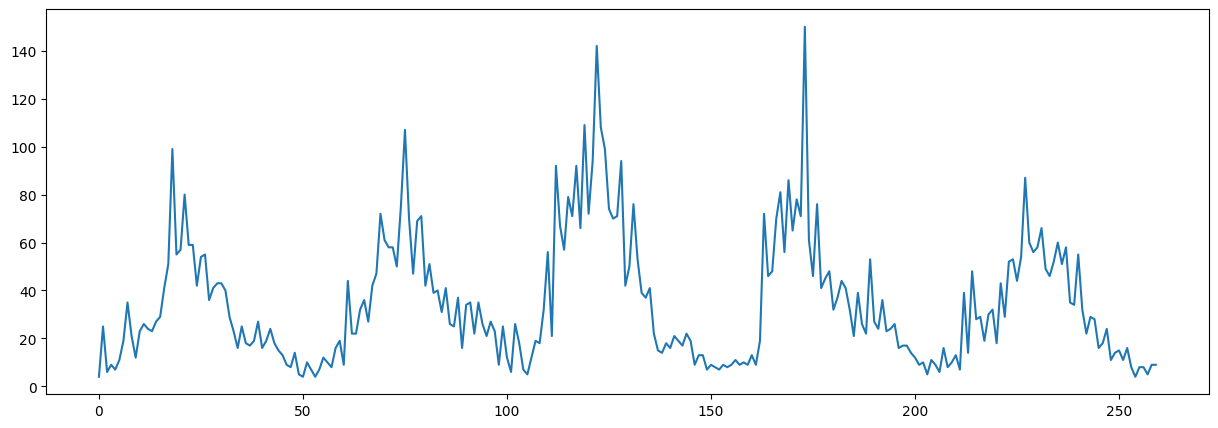

In [5]:
# Specify modelling parameters
label_lags=(3,4)
feature_lags = (3,)
feature_names = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]
lagged_features = feature_names

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,labels=train_labels,
                                                            features_to_keep = feature_names,
                                                            lagged_features = lagged_features,
                                                            fillna = 'ffill', feature_lags=feature_lags,
                                                            label_lags=label_lags,circular_weekofyear=True)

# Drop city column if training cities separately
sj_features.drop(columns=['city_sj','weekofyear_3'],inplace=True)

# X_train_sj, X_val_sj, y_train_sj, y_val_sj,\
#     _, _, _, _ = prep_data(sj_features, iq_features,sj_labels, iq_labels,
#                            folds=6, fold_size=0.15)
# X_train_sj = pd.concat([X_train_sj[0], X_val_sj[0]],axis=0)
# y_train_sj = pd.concat([y_train_sj[0], y_val_sj[0]],axis=0)

# Reducing all lagged label weights to reduce their selection
feature_weights = 100*np.ones(sj_features.shape[1])
if label_lags is not None:
    feature_weights[-len(label_lags):] = 1
else:
    lagged_label_names = []

model_sj = create_XGBmodel(eta=0.01,n_estimators=500,max_depth=5,
                                     objective='reg:squarederror',
                                     reg_alpha=1,reg_lambda=1)

modelfit(model_sj, sj_features, sj_labels,
        useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
        trainCV_metrics = 'mae', eval_metric = 'mae',
        report_metric = metrics.mean_absolute_error, verbose=False,
        feature_weights=feature_weights)
if label_lags is not None:
    lagged_label_names = ['total_cases_'+str(i) for i in label_lags]
else:
    lagged_label_names = []

sj_pred_features_aug, _, _, _ = preprocess(test_features_aug_or,
                                  features_to_keep = feature_names + lagged_label_names,
                                  lagged_features = lagged_features,
                                  fillna = 'ffill', feature_lags=feature_lags,
                                  label_lags=None,circular_weekofyear=True)
sj_pred_features_aug.drop(columns='weekofyear_3',inplace=True)

# Get predicted values
sj_mask = sj_pred_features_aug['city_sj']
iq_mask = ~sj_mask
sj_pred_features_aug = sj_pred_features_aug.copy().loc[sj_mask,[col for col in sj_pred_features_aug.columns if col != 'city_sj']]
order_needed = sj_features.columns.to_list()
sj_pred_features_aug = sj_pred_features_aug[order_needed]
sj_sub_pred = get_predictions(model_sj, sj_pred_features_aug, label_lags)

# sj_sub_pred = medfilt(sj_sub_pred,3)

fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(sj_sub_pred)

In [6]:
# sj_features.to_csv('sj_train_features_new.csv',index=None)
# sj_labels.to_csv('sj_train_labels_new.csv',index=None)
# sj_pred_features_aug.to_csv('sj_pred_features_new.csv',index=None)

## Compare

In [13]:
sj_features_new = pd.read_csv('sj_train_features_new.csv')
sj_labels_new = pd.read_csv('sj_train_labels_new.csv')
sj_pred_features_new = pd.read_csv('sj_pred_features_new.csv')

sj_features_old = pd.read_csv('sj_train_features_old2.csv')
sj_labels_old = pd.read_csv('sj_train_labels_old2.csv')
sj_pred_features_old = pd.read_csv('sj_pred_features_old2.csv')

In [14]:
print(sj_features_new.shape,sj_labels_new.shape,sj_pred_features_new.shape)
print(sj_features_old.shape,sj_labels_old.shape,sj_pred_features_old.shape)

(936, 43) (936, 1) (260, 43)
(936, 43) (936, 1) (260, 43)


In [16]:
sj_features_old[sj_features_new.columns].equals(sj_features_new)

True

In [17]:
sj_pred_features_old[sj_pred_features_new.columns].equals(sj_pred_features_new)

True

In [18]:
sj_labels_old.equals(sj_labels_new)

True